In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import plotly.graph_objs as go
# import plotly.offline as py
# import plotly.tools as tls
# import seaborn as sns
# import scipy.io.wavfile
import scipy
import csv
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
df=pd.read_csv('dataset.csv', index_col=0)
mfccs=pd.read_csv('mfccs.csv', header=None)
delta=pd.read_csv('delta.csv', header=None)
delta2=pd.read_csv('delta2.csv', header=None)

In [6]:
data=[df,mfccs]
data=pd.concat(data,axis=1)

In [48]:
data.head()

,path,actor,gender,emotion_label,emotion,0,1,2,3,4,...,118,119,120,121,122,123,124,125,126,127
0,RAVDESS/Actor_01/03-01-01-01-01-01-01.wav,1,male,neutral,1,-807.093833,29.387792,-7.994968,2.463625,-6.305849,...,0.163665,0.058751,-0.178047,0.109251,0.158215,-0.064029,-0.032839,0.001606,0.098609,0.008178
1,RAVDESS/Actor_01/03-01-01-01-01-02-01.wav,1,male,neutral,1,-812.872998,28.134680,-7.182937,2.928107,-6.658621,...,0.018255,-0.062751,-0.078886,0.119928,0.112046,-0.098666,-0.006012,-0.052207,-0.027280,0.110209
2,RAVDESS/Actor_01/03-01-01-01-02-01-01.wav,1,male,neutral,1,-800.394962,28.677283,-7.306341,1.799505,-6.618760,...,0.004670,-0.031283,0.005720,0.089850,0.025061,-0.065976,0.027956,-0.027175,0.022315,0.044782
3,RAVDESS/Actor_01/03-01-01-01-02-02-01.wav,1,male,neutral,1,-807.089031,26.900829,-5.859483,2.263658,-6.231354,...,-0.063829,0.116476,0.054030,-0.004090,0.113386,-0.032039,-0.012421,0.041892,0.038828,0.033723
4,RAVDESS/Actor_01/03-01-02-01-01-01-01.wav,1,male,calm,2,-839.173372,34.161749,-6.995195,3.355403,-6.705248,...,0.122866,-0.165572,-0.074169,0.157026,0.115957,-0.169827,-0.186208,0.070685,0.057332,-0.027393


In [50]:
data.iloc[:,5:26]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-807.093833,29.387792,-7.994968,2.463625,-6.305849,-6.814599,-3.242635,-2.038813,-0.406622,-1.056465,...,-2.770175,-1.925038,-2.999787,-2.047193,-2.359427,-1.231189,-1.670190,-2.397534,-0.932087,-3.001437
1,-812.872998,28.134680,-7.182937,2.928107,-6.658621,-6.525178,-2.849974,-2.072607,-0.286251,-1.472068,...,-2.219922,-1.885399,-2.995535,-2.289678,-2.431905,-1.026744,-1.867139,-2.149440,-1.012673,-3.031888
2,-800.394962,28.677283,-7.306341,1.799505,-6.618760,-5.489153,-3.567977,-2.043469,-0.164583,-1.340146,...,-2.439707,-1.384747,-2.278056,-1.418129,-2.498380,-1.289788,-1.248533,-2.676838,-0.638227,-2.949223
3,-807.089031,26.900829,-5.859483,2.263658,-6.231354,-5.391140,-3.887278,-1.883529,-0.093242,-1.910786,...,-2.286113,-1.390798,-2.681700,-2.160084,-2.451102,-1.481333,-1.811141,-2.696427,-0.653615,-2.793904
4,-839.173372,34.161749,-6.995195,3.355403,-6.705248,-6.395046,-3.728030,-1.550061,-0.833339,-1.196048,...,-3.399974,-2.025615,-3.292423,-2.323526,-2.531106,-1.083968,-1.773705,-2.220262,-0.477276,-3.455368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-726.049943,11.143951,-17.542104,-6.003230,-11.295105,-5.483826,-5.078249,-0.789207,0.313604,-1.291990,...,-0.202528,-0.920560,0.689947,0.624337,3.093217,-0.017252,-1.372436,0.464570,-0.819771,-1.323300
1436,-654.198868,22.965204,-22.998512,-8.963004,-12.987737,-4.563436,-2.708016,-1.895550,0.275308,-2.057219,...,-0.999758,0.157103,5.389430,2.266731,3.037347,1.296353,-1.124570,-0.412837,-1.503796,-1.426501
1437,-670.822450,18.442533,-23.675205,-7.061895,-13.555098,-4.670575,-0.903702,-1.385729,0.041512,-2.799571,...,0.780138,0.839132,3.404654,0.072250,1.561526,0.689652,-0.704118,0.733347,-1.499863,-0.617189
1438,-639.223928,16.057828,-14.919054,-3.117970,-10.144983,-1.920158,-5.690462,-2.955144,-2.625087,-1.627450,...,2.541008,4.597194,4.112929,1.156446,2.524873,-1.723374,-1.156368,-0.582830,-0.033031,-0.130608


In [7]:
X=data.iloc[:,5:26].values
#y=data['emotion'].values
y=pd.get_dummies(data['emotion']).values

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=42)

In [58]:
y_train.shape

(1296,)

In [53]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [54]:
y_pred = dtree.predict(X_test)

In [55]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.74      0.68      0.71        25
           2       0.50      0.42      0.46        19
           3       0.36      0.67      0.47        12
           4       0.48      0.56      0.51        18
           5       0.52      0.61      0.56        18
           6       0.47      0.50      0.49        18
           7       0.53      0.32      0.40        25

   micro avg       0.52      0.52      0.52       144
   macro avg       0.52      0.52      0.51       144
weighted avg       0.54      0.52      0.52       144
 samples avg       0.52      0.52      0.52       144



In [59]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)
rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=22000, random_state=5)

In [60]:
y_pred = rforest.predict(X_test)

In [62]:
y_pred

array([7, 2, 3, 2, 7, 2, 2, 6, 3, 2, 7, 8, 4, 6, 2, 7, 5, 6, 2, 3, 3, 2,
       1, 2, 6, 4, 6, 7, 7, 7, 7, 5, 6, 7, 7, 2, 7, 5, 6, 7, 2, 1, 2, 5,
       8, 2, 2, 4, 6, 6, 4, 6, 3, 6, 2, 7, 2, 2, 8, 4, 2, 6, 8, 6, 6, 6,
       2, 2, 7, 4, 6, 3, 2, 3, 5, 2, 5, 8, 2, 7, 3, 3, 5, 2, 3, 5, 6, 2,
       4, 2, 1, 2, 5, 7, 2, 7, 7, 5, 3, 3, 7, 6, 6, 7, 1, 6, 8, 7, 6, 2,
       8, 5, 8, 4, 7, 8, 5, 7, 2, 6, 6, 2, 8, 5, 5, 5, 8, 4, 6, 6, 5, 8,
       2, 4, 3, 4, 2, 2, 7, 7, 7, 7, 6, 3], dtype=int64)

ERROR! Session/line number was not unique in database. History logging moved to new session 140


In [63]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.75      0.33      0.46         9
           2       0.65      0.88      0.75        25
           3       0.50      0.37      0.42        19
           4       0.45      0.42      0.43        12
           5       0.56      0.50      0.53        18
           6       0.50      0.72      0.59        18
           7       0.52      0.78      0.62        18
           8       0.67      0.32      0.43        25

    accuracy                           0.56       144
   macro avg       0.57      0.54      0.53       144
weighted avg       0.58      0.56      0.54       144



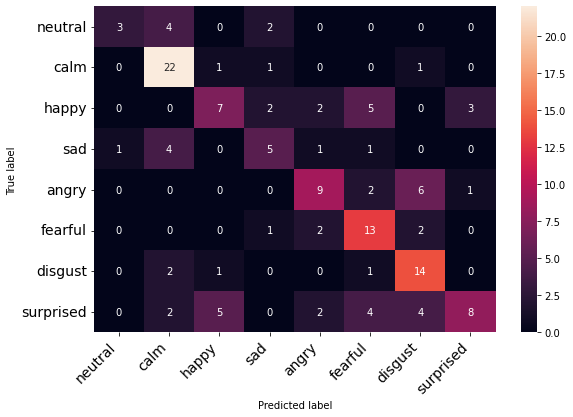

In [77]:
c=confusion_matrix(y_test,y_pred)
print_confusion_matrix(c, class_names)

In [10]:
X_train_cnn=np.expand_dims(X_train, axis=2)
X_test_cnn=np.expand_dims(X_test, axis=2)

In [99]:
X_train_cnn.shape

(1296, 21, 1)

In [100]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(X_train_cnn.shape[1],1)))
model.add(Activation('relu'))
# model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = optimizers.rmsprop(lr=0.00005, rho=0.9, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
cnnhistory=model.fit(X_train_cnn, y_train, batch_size=16, epochs=1000, validation_data=(X_test_cnn, y_test))


Train on 1296 samples, validate on 144 samples
Epoch 1/1000
1296/1296 [==============================] - 1s 982us/step - loss: 2.0407 - accuracy: 0.1960 - val_loss: 2.0127 - val_accuracy: 0.2153
Epoch 2/1000
1296/1296 [==============================] - 1s 633us/step - loss: 2.0098 - accuracy: 0.2083 - val_loss: 1.9835 - val_accuracy: 0.2361
Epoch 3/1000
1296/1296 [==============================] - 1s 573us/step - loss: 1.9853 - accuracy: 0.2346 - val_loss: 1.9634 - val_accuracy: 0.2222
Epoch 4/1000
1296/1296 [==============================] - 1s 568us/step - loss: 1.9667 - accuracy: 0.2492 - val_loss: 1.9412 - val_accuracy: 0.2569
Epoch 5/1000
1296/1296 [==============================] - 1s 542us/step - loss: 1.9549 - accuracy: 0.2485 - val_loss: 1.9245 - val_accuracy: 0.2917
Epoch 6/1000
1296/1296 [==============================] - 1s 619us/step - loss: 1.9402 - accuracy: 0.2569 - val_loss: 1.9100 - val_accuracy: 0.3056
Epoch 7/1000
1296/1296 [==============================] - 1s 548u

Epoch 56/1000
1296/1296 [==============================] - 1s 720us/step - loss: 1.6593 - accuracy: 0.3765 - val_loss: 1.5884 - val_accuracy: 0.4167
Epoch 57/1000
1296/1296 [==============================] - 1s 682us/step - loss: 1.6520 - accuracy: 0.3835 - val_loss: 1.5889 - val_accuracy: 0.4167
Epoch 58/1000
1296/1296 [==============================] - 1s 586us/step - loss: 1.6563 - accuracy: 0.3758 - val_loss: 1.5821 - val_accuracy: 0.4167
Epoch 59/1000
1296/1296 [==============================] - 1s 620us/step - loss: 1.6472 - accuracy: 0.3912 - val_loss: 1.5773 - val_accuracy: 0.4375
Epoch 60/1000
1296/1296 [==============================] - 1s 609us/step - loss: 1.6430 - accuracy: 0.3889 - val_loss: 1.5736 - val_accuracy: 0.4167
Epoch 61/1000
1296/1296 [==============================] - 1s 708us/step - loss: 1.6463 - accuracy: 0.3920 - val_loss: 1.5718 - val_accuracy: 0.4375
Epoch 62/1000
1296/1296 [==============================] - 1s 704us/step - loss: 1.6297 - accuracy: 0.4028

Epoch 111/1000
1296/1296 [==============================] - 1s 715us/step - loss: 1.4953 - accuracy: 0.4537 - val_loss: 1.4389 - val_accuracy: 0.5139
Epoch 112/1000
1296/1296 [==============================] - 1s 729us/step - loss: 1.4868 - accuracy: 0.4637 - val_loss: 1.4330 - val_accuracy: 0.4931
Epoch 113/1000
1296/1296 [==============================] - 1s 700us/step - loss: 1.4888 - accuracy: 0.4522 - val_loss: 1.4286 - val_accuracy: 0.5000
Epoch 114/1000
1296/1296 [==============================] - 1s 662us/step - loss: 1.4852 - accuracy: 0.4630 - val_loss: 1.4350 - val_accuracy: 0.5069
Epoch 115/1000
1296/1296 [==============================] - 1s 688us/step - loss: 1.4867 - accuracy: 0.4529 - val_loss: 1.4250 - val_accuracy: 0.5000
Epoch 116/1000
1296/1296 [==============================] - 1s 729us/step - loss: 1.4831 - accuracy: 0.4606 - val_loss: 1.4245 - val_accuracy: 0.5000
Epoch 117/1000
1296/1296 [==============================] - 1s 598us/step - loss: 1.4771 - accuracy:

Epoch 220/1000
1296/1296 [==============================] - 1s 709us/step - loss: 1.2767 - accuracy: 0.5424 - val_loss: 1.3151 - val_accuracy: 0.5486
Epoch 221/1000
1296/1296 [==============================] - 1s 703us/step - loss: 1.2654 - accuracy: 0.5525 - val_loss: 1.3192 - val_accuracy: 0.5556
Epoch 222/1000
1296/1296 [==============================] - 1s 625us/step - loss: 1.2715 - accuracy: 0.5440 - val_loss: 1.3216 - val_accuracy: 0.5486
Epoch 223/1000
1296/1296 [==============================] - 1s 716us/step - loss: 1.2693 - accuracy: 0.5509 - val_loss: 1.3218 - val_accuracy: 0.5486
Epoch 224/1000
1296/1296 [==============================] - 1s 708us/step - loss: 1.2724 - accuracy: 0.5417 - val_loss: 1.3199 - val_accuracy: 0.5486
Epoch 225/1000
1296/1296 [==============================] - 1s 594us/step - loss: 1.2685 - accuracy: 0.5455 - val_loss: 1.3220 - val_accuracy: 0.5556
Epoch 226/1000
1296/1296 [==============================] - 1s 674us/step - loss: 1.2664 - accuracy:

Epoch 329/1000
1296/1296 [==============================] - 1s 729us/step - loss: 1.1088 - accuracy: 0.6049 - val_loss: 1.2882 - val_accuracy: 0.5833
Epoch 330/1000
1296/1296 [==============================] - 1s 821us/step - loss: 1.1085 - accuracy: 0.6157 - val_loss: 1.2897 - val_accuracy: 0.5764
Epoch 331/1000
1296/1296 [==============================] - 1s 810us/step - loss: 1.1082 - accuracy: 0.6134 - val_loss: 1.2909 - val_accuracy: 0.5833
Epoch 332/1000
1296/1296 [==============================] - 1s 742us/step - loss: 1.1026 - accuracy: 0.6026 - val_loss: 1.2839 - val_accuracy: 0.5833
Epoch 333/1000
1296/1296 [==============================] - 1s 791us/step - loss: 1.1119 - accuracy: 0.6142 - val_loss: 1.2875 - val_accuracy: 0.5694
Epoch 334/1000
1296/1296 [==============================] - 1s 775us/step - loss: 1.1003 - accuracy: 0.6026 - val_loss: 1.2842 - val_accuracy: 0.5833
Epoch 335/1000
1296/1296 [==============================] - 1s 715us/step - loss: 1.0981 - accuracy:

Epoch 438/1000
1296/1296 [==============================] - 1s 643us/step - loss: 0.9852 - accuracy: 0.6613 - val_loss: 1.2918 - val_accuracy: 0.5556
Epoch 439/1000
1296/1296 [==============================] - 1s 709us/step - loss: 0.9674 - accuracy: 0.6590 - val_loss: 1.2892 - val_accuracy: 0.5486
Epoch 440/1000
1296/1296 [==============================] - 1s 684us/step - loss: 0.9721 - accuracy: 0.6628 - val_loss: 1.3129 - val_accuracy: 0.5625
Epoch 441/1000
1296/1296 [==============================] - 1s 674us/step - loss: 0.9821 - accuracy: 0.6659 - val_loss: 1.3121 - val_accuracy: 0.5486
Epoch 442/1000
1296/1296 [==============================] - 1s 718us/step - loss: 0.9713 - accuracy: 0.6667 - val_loss: 1.2901 - val_accuracy: 0.5486
Epoch 443/1000
1296/1296 [==============================] - 1s 719us/step - loss: 0.9692 - accuracy: 0.6705 - val_loss: 1.2867 - val_accuracy: 0.5417
Epoch 444/1000
1296/1296 [==============================] - 1s 644us/step - loss: 0.9778 - accuracy:

Epoch 547/1000
1296/1296 [==============================] - 1s 637us/step - loss: 0.8620 - accuracy: 0.7037 - val_loss: 1.3061 - val_accuracy: 0.5486
Epoch 548/1000
1296/1296 [==============================] - 1s 608us/step - loss: 0.8601 - accuracy: 0.6998 - val_loss: 1.2955 - val_accuracy: 0.5486
Epoch 549/1000
1296/1296 [==============================] - 1s 693us/step - loss: 0.8666 - accuracy: 0.7060 - val_loss: 1.2925 - val_accuracy: 0.5486
Epoch 550/1000
1296/1296 [==============================] - 1s 692us/step - loss: 0.8678 - accuracy: 0.6998 - val_loss: 1.2890 - val_accuracy: 0.5417
Epoch 551/1000
1296/1296 [==============================] - 1s 708us/step - loss: 0.8512 - accuracy: 0.7160 - val_loss: 1.2973 - val_accuracy: 0.5625
Epoch 552/1000
1296/1296 [==============================] - 1s 634us/step - loss: 0.8554 - accuracy: 0.7022 - val_loss: 1.2997 - val_accuracy: 0.5556
Epoch 553/1000
1296/1296 [==============================] - 1s 694us/step - loss: 0.8652 - accuracy:

1296/1296 [==============================] - 1s 706us/step - loss: 0.7531 - accuracy: 0.7477 - val_loss: 1.2989 - val_accuracy: 0.5625
Epoch 656/1000
1296/1296 [==============================] - 1s 698us/step - loss: 0.7587 - accuracy: 0.7415 - val_loss: 1.2809 - val_accuracy: 0.5625
Epoch 657/1000
1296/1296 [==============================] - 1s 729us/step - loss: 0.7549 - accuracy: 0.7461 - val_loss: 1.2900 - val_accuracy: 0.5556
Epoch 658/1000
1296/1296 [==============================] - 1s 737us/step - loss: 0.7577 - accuracy: 0.7515 - val_loss: 1.2901 - val_accuracy: 0.5347
Epoch 659/1000
1296/1296 [==============================] - 1s 716us/step - loss: 0.7495 - accuracy: 0.7508 - val_loss: 1.2982 - val_accuracy: 0.5556
Epoch 660/1000
1296/1296 [==============================] - 1s 654us/step - loss: 0.7576 - accuracy: 0.7531 - val_loss: 1.3110 - val_accuracy: 0.5486
Epoch 661/1000
1296/1296 [==============================] - 1s 724us/step - loss: 0.7625 - accuracy: 0.7407 - val_l

Epoch 710/1000
1296/1296 [==============================] - 1s 728us/step - loss: 0.7161 - accuracy: 0.7639 - val_loss: 1.3003 - val_accuracy: 0.5347
Epoch 711/1000
1296/1296 [==============================] - 1s 640us/step - loss: 0.7095 - accuracy: 0.7716 - val_loss: 1.3144 - val_accuracy: 0.5486
Epoch 712/1000
1296/1296 [==============================] - 1s 662us/step - loss: 0.7007 - accuracy: 0.7539 - val_loss: 1.2887 - val_accuracy: 0.5417
Epoch 713/1000
1296/1296 [==============================] - 1s 656us/step - loss: 0.7115 - accuracy: 0.7631 - val_loss: 1.2889 - val_accuracy: 0.5417
Epoch 714/1000
1296/1296 [==============================] - 1s 653us/step - loss: 0.7201 - accuracy: 0.7631 - val_loss: 1.2883 - val_accuracy: 0.5486
Epoch 715/1000
1296/1296 [==============================] - 1s 646us/step - loss: 0.7029 - accuracy: 0.7778 - val_loss: 1.3062 - val_accuracy: 0.5278
Epoch 716/1000
1296/1296 [==============================] - 1s 657us/step - loss: 0.7150 - accuracy:

Epoch 819/1000
1296/1296 [==============================] - 1s 619us/step - loss: 0.6112 - accuracy: 0.8048 - val_loss: 1.3292 - val_accuracy: 0.5417
Epoch 820/1000
1296/1296 [==============================] - 1s 603us/step - loss: 0.6248 - accuracy: 0.8025 - val_loss: 1.3194 - val_accuracy: 0.5556
Epoch 821/1000
1296/1296 [==============================] - 1s 646us/step - loss: 0.6214 - accuracy: 0.7940 - val_loss: 1.2977 - val_accuracy: 0.5556
Epoch 822/1000
1296/1296 [==============================] - 1s 651us/step - loss: 0.6267 - accuracy: 0.7909 - val_loss: 1.3061 - val_accuracy: 0.5556
Epoch 823/1000
1296/1296 [==============================] - 1s 657us/step - loss: 0.6238 - accuracy: 0.7878 - val_loss: 1.2876 - val_accuracy: 0.5694
Epoch 824/1000
1296/1296 [==============================] - 1s 654us/step - loss: 0.6185 - accuracy: 0.7986 - val_loss: 1.3272 - val_accuracy: 0.5486
Epoch 825/1000
1296/1296 [==============================] - 1s 665us/step - loss: 0.6219 - accuracy:

1296/1296 [==============================] - 1s 733us/step - loss: 0.5347 - accuracy: 0.8241 - val_loss: 1.3324 - val_accuracy: 0.5556
Epoch 928/1000
1296/1296 [==============================] - 1s 653us/step - loss: 0.5339 - accuracy: 0.8318 - val_loss: 1.3330 - val_accuracy: 0.5556
Epoch 929/1000
1296/1296 [==============================] - 1s 642us/step - loss: 0.5334 - accuracy: 0.8310 - val_loss: 1.3283 - val_accuracy: 0.5625
Epoch 930/1000
1296/1296 [==============================] - 1s 679us/step - loss: 0.5229 - accuracy: 0.8264 - val_loss: 1.3134 - val_accuracy: 0.5625
Epoch 931/1000
1296/1296 [==============================] - 1s 629us/step - loss: 0.5437 - accuracy: 0.8279 - val_loss: 1.3124 - val_accuracy: 0.5694
Epoch 932/1000
1296/1296 [==============================] - 1s 704us/step - loss: 0.5408 - accuracy: 0.8318 - val_loss: 1.3095 - val_accuracy: 0.5903
Epoch 933/1000
1296/1296 [==============================] - 1s 655us/step - loss: 0.5330 - accuracy: 0.8233 - val_l

Epoch 982/1000
1296/1296 [==============================] - 1s 621us/step - loss: 0.5066 - accuracy: 0.8426 - val_loss: 1.3169 - val_accuracy: 0.5764
Epoch 983/1000
1296/1296 [==============================] - 1s 510us/step - loss: 0.5010 - accuracy: 0.8434 - val_loss: 1.3690 - val_accuracy: 0.5486
Epoch 984/1000
1296/1296 [==============================] - 1s 532us/step - loss: 0.5036 - accuracy: 0.8426 - val_loss: 1.3401 - val_accuracy: 0.5694
Epoch 985/1000
1296/1296 [==============================] - 1s 617us/step - loss: 0.5033 - accuracy: 0.8511 - val_loss: 1.3178 - val_accuracy: 0.5694
Epoch 986/1000
1296/1296 [==============================] - 1s 608us/step - loss: 0.4964 - accuracy: 0.8457 - val_loss: 1.3142 - val_accuracy: 0.5694
Epoch 987/1000
1296/1296 [==============================] - 1s 676us/step - loss: 0.4960 - accuracy: 0.8472 - val_loss: 1.3442 - val_accuracy: 0.5625
Epoch 988/1000
1296/1296 [==============================] - 1s 663us/step - loss: 0.4941 - accuracy:

In [91]:
y_pred=model.predict(X_test_cnn)

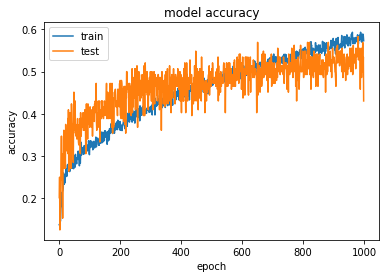

In [90]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.86      0.48      0.62        25
           2       0.33      0.16      0.21        19
           3       0.18      0.33      0.24        12
           4       0.48      0.72      0.58        18
           5       0.45      0.50      0.47        18
           6       0.39      0.83      0.54        18
           7       0.43      0.24      0.31        25

    accuracy                           0.43       144
   macro avg       0.39      0.41      0.37       144
weighted avg       0.45      0.43      0.41       144



C:\Users\HP\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
model = Sequential(name="basic CNN")
model.add(Conv1D(256, 12,  strides=3, padding='same', data_format='channels_last',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4, stride=4))
model.add(Dropout(0.4))

model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_size=4, stride=4))
model.add(Dropout(0.5))

model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_size=4, stride=4))
model.add(Dropout(0.5))

# model.add(Conv1D(128, 8, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# #model.add(MaxPooling1D(pool_size=4, stride=4))
# model.add(Dropout(0.5))

model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_size=4, stride=4))
model.add(Dropout(0.5))
          
model.add(Conv1D(64, 8, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(32, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))


ERROR! Session/line number was not unique in database. History logging moved to new session 163


C:\Users\HP\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=4, strides=4)`
  


In [14]:
opt= optimizers.Adam(lr=0.00001, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [229]:
model.summary()

Model: "basic CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_265 (Conv1D)          (None, 128, 128)          1664      
_________________________________________________________________
activation_267 (Activation)  (None, 128, 128)          0         
_________________________________________________________________
conv1d_266 (Conv1D)          (None, 128, 128)          131200    
_________________________________________________________________
batch_normalization_158 (Bat (None, 128, 128)          512       
_________________________________________________________________
activation_268 (Activation)  (None, 128, 128)          0         
_________________________________________________________________
dropout_159 (Dropout)        (None, 128, 128)          0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 128, 128)          13

In [117]:
X_train.shape

(1296, 128)

In [34]:
len(np.unique(np.argmax(y, 1)))

8

In [43]:
batch_size = 16
num_epochs = 200
#1000
# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', patience=20)
# Please change the model name +accordingly.
mcp_save = ModelCheckpoint('models/Audio_1DCNN_k12_2.h5', save_best_only=True, monitor='accuracy', mode='max')
cnnhistory=model.fit(X_train_cnn, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_test_cnn, y_test), callbacks=[mcp_save])

Train on 1296 samples, validate on 144 samples
Epoch 1/200
ERROR! Session/line number was not unique in database. History logging moved to new session 166
1296/1296 [==============================] - 2s 2ms/step - loss: 0.6018 - accuracy: 0.7739 - val_loss: 1.2429 - val_accuracy: 0.6250
Epoch 2/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.6168 - accuracy: 0.7739 - val_loss: 1.2263 - val_accuracy: 0.6250
Epoch 3/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5936 - accuracy: 0.7785 - val_loss: 1.2040 - val_accuracy: 0.6319
Epoch 4/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5848 - accuracy: 0.7863 - val_loss: 1.2309 - val_accuracy: 0.6250
Epoch 5/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5834 - accuracy: 0.7971 - val_loss: 1.2327 - val_accuracy: 0.6597
Epoch 6/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5825 - accuracy: 0.7863 - val_loss: 1.2147 - val_accu

1296/1296 [==============================] - 2s 1ms/step - loss: 0.5780 - accuracy: 0.7847 - val_loss: 1.2300 - val_accuracy: 0.6389
Epoch 57/200
1296/1296 [==============================] - 2s 1ms/step - loss: 0.6134 - accuracy: 0.7785 - val_loss: 1.2248 - val_accuracy: 0.6528
Epoch 58/200
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5649 - accuracy: 0.8048 - val_loss: 1.2259 - val_accuracy: 0.6319
Epoch 59/200
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5798 - accuracy: 0.7840 - val_loss: 1.2392 - val_accuracy: 0.6319
Epoch 60/200
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5459 - accuracy: 0.8048 - val_loss: 1.2541 - val_accuracy: 0.6389
Epoch 61/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5114 - accuracy: 0.8063 - val_loss: 1.2607 - val_accuracy: 0.6458
Epoch 62/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5340 - accuracy: 0.7971 - val_loss: 1.2320 - val_accuracy

1296/1296 [==============================] - 2s 2ms/step - loss: 0.5336 - accuracy: 0.8040 - val_loss: 1.2409 - val_accuracy: 0.6736
Epoch 113/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.4877 - accuracy: 0.8218 - val_loss: 1.2268 - val_accuracy: 0.6806
Epoch 114/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5617 - accuracy: 0.8071 - val_loss: 1.2309 - val_accuracy: 0.6458
Epoch 115/200
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5709 - accuracy: 0.8025 - val_loss: 1.2801 - val_accuracy: 0.6458
Epoch 116/200
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5110 - accuracy: 0.8148 - val_loss: 1.2463 - val_accuracy: 0.6389
Epoch 117/200
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5200 - accuracy: 0.8071 - val_loss: 1.2469 - val_accuracy: 0.6319
Epoch 118/200
1296/1296 [==============================] - 3s 2ms/step - loss: 0.4915 - accuracy: 0.8318 - val_loss: 1.2643 - val_ac

Epoch 168/200
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5122 - accuracy: 0.8179 - val_loss: 1.3224 - val_accuracy: 0.6319
Epoch 169/200
1296/1296 [==============================] - 3s 2ms/step - loss: 0.4333 - accuracy: 0.8488 - val_loss: 1.3041 - val_accuracy: 0.6458
Epoch 170/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.4769 - accuracy: 0.8326 - val_loss: 1.2995 - val_accuracy: 0.6389
Epoch 171/200
1296/1296 [==============================] - 4s 3ms/step - loss: 0.5082 - accuracy: 0.8218 - val_loss: 1.2975 - val_accuracy: 0.6458
Epoch 172/200
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5060 - accuracy: 0.8218 - val_loss: 1.2595 - val_accuracy: 0.6458
Epoch 173/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.4493 - accuracy: 0.8333 - val_loss: 1.2760 - val_accuracy: 0.6736
Epoch 174/200
1296/1296 [==============================] - 2s 2ms/step - loss: 0.4727 - accuracy: 0.8326 - val_loss: 1

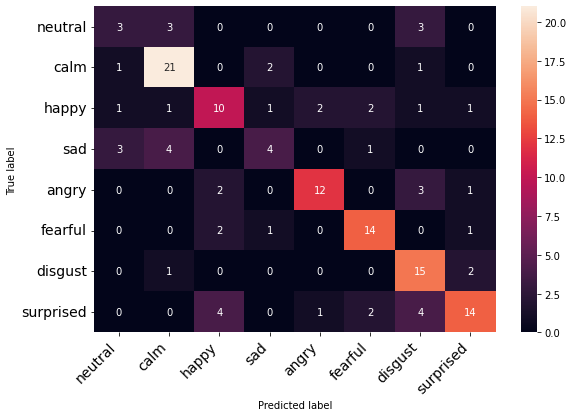

In [48]:
print_confusion_matrix(c, class_names)

In [49]:
max(cnnhistory.history['val_accuracy'])

0.6805555820465088

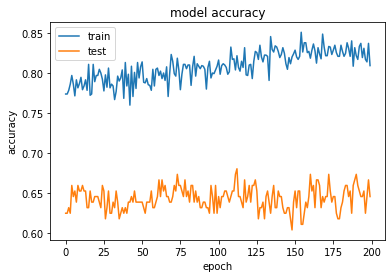

In [47]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

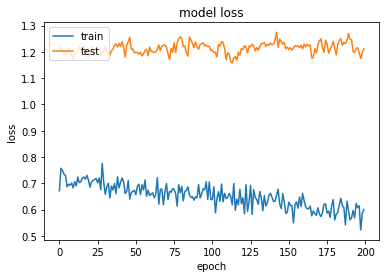

In [39]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
import json
model_json = model.to_json()
with open("Models/Audio_1DCNN_LogMelModel_5L.json", "w") as json_file:
    json_file.write(model_json)

In [50]:
y_pred=model.predict(X_test_cnn)

In [26]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,6), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

ERROR! Session/line number was not unique in database. History logging moved to new session 164


In [27]:
class_names=['neutral','calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

ERROR! Session/line number was not unique in database. History logging moved to new session 165


In [51]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.38      0.33      0.35         9
           1       0.70      0.84      0.76        25
           2       0.56      0.53      0.54        19
           3       0.50      0.33      0.40        12
           4       0.80      0.67      0.73        18
           5       0.74      0.78      0.76        18
           6       0.56      0.83      0.67        18
           7       0.74      0.56      0.64        25

    accuracy                           0.65       144
   macro avg       0.62      0.61      0.61       144
weighted avg       0.65      0.65      0.64       144



In [181]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.85      0.88      0.86        25
           2       0.45      0.53      0.49        19
           3       0.50      0.67      0.57        12
           4       0.65      0.61      0.63        18
           5       0.61      0.78      0.68        18
           6       0.57      0.44      0.50        18
           7       0.74      0.56      0.64        25

    accuracy                           0.62       144
   macro avg       0.60      0.60      0.59       144
weighted avg       0.63      0.62      0.62       144



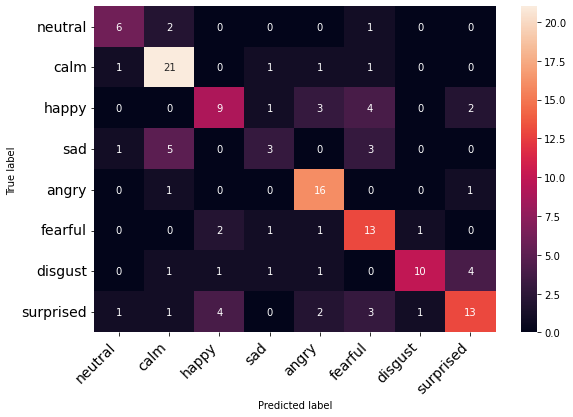

In [249]:
print_confusion_matrix(c, class_names)

In [62]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=256))

# FC
model.add(Dense(units=8, activation='softmax'))

# Model compilation
opt= optimizers.Adam(lr=0.001, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

ERROR! Session/line number was not unique in database. History logging moved to new session 78


In [63]:
batch_size = 16
num_epochs = 100

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('models/Audio_1DCNN_k12.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_test, y_test), callbacks=[mcp_save, lr_reduce])

Train on 1296 samples, validate on 144 samples
Epoch 1/100
1296/1296 [==============================] - 5s 4ms/step - loss: 2.0704 - categorical_accuracy: 0.1304 - val_loss: 2.0983 - val_categorical_accuracy: 0.1736
Epoch 2/100
1296/1296 [==============================] - 2s 2ms/step - loss: 2.0087 - categorical_accuracy: 0.1852 - val_loss: 2.1498 - val_categorical_accuracy: 0.1736l_accuracy: 0.
Epoch 3/100
1296/1296 [==============================] - 2s 2ms/step - loss: 1.9332 - categorical_accuracy: 0.2215 - val_loss: 2.0655 - val_categorical_accuracy: 0.2500
Epoch 4/100
1296/1296 [==============================] - 2s 2ms/step - loss: 1.9091 - categorical_accuracy: 0.2384 - val_loss: 1.8697 - val_categorical_accuracy: 0.2778 ETA: 0s - loss: 1.9125 - categorical_accuracy: 0.23
Epoch 5/100
1296/1296 [==============================] - 2s 2ms/step - loss: 1.9292 - categorical_accuracy: 0.2276 - val_loss: 1.8272 - val_categorical_accuracy: 0.2361
Epoch 6/100
1296/1296 [===================

1296/1296 [==============================] - 2s 1ms/step - loss: 1.6883 - categorical_accuracy: 0.3403 - val_loss: 2.2553 - val_categorical_accuracy: 0.2292 1.6877 - categorical_accuracy: 0.34 - ETA: 1s - loss: 1.6766 - categorical_accuracy: 0. - ETA: 0s - loss: 1.6763 - catego - ETA: 0s - loss: 1.6979 - categorical_accuracy:  - ETA: 0s - loss: 1.6881 - categorical_accuracy: 0.34
Epoch 84/100
1296/1296 [==============================] - 2s 1ms/step - loss: 1.6895 - categorical_accuracy: 0.3472 - val_loss: 2.4489 - val_categorical_accuracy: 0.1944oss: 1.6896 - categorical_accuracy: 0.
Epoch 85/100
1296/1296 [==============================] - ETA: 0s - loss: 1.6827 - categorical_accuracy: 0.3370 ETA: 1s - loss: 1.7189 - categorical_accuracy - ETA: 1s - loss: 1.7368 - categorical_accu - ETA: 1s - loss: 1.7414 - categorical_accuracy: 0. - ETA: 0s - loss: 1.7239 - categorical_accuracy: 0.31 - ETA: 0s - loss: 1.7190 - categorical_accuracy - ETA: 0s - loss: 1.7006 - categori - 2s 1ms/step - l

In [44]:
def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

In [46]:
import seaborn as sns

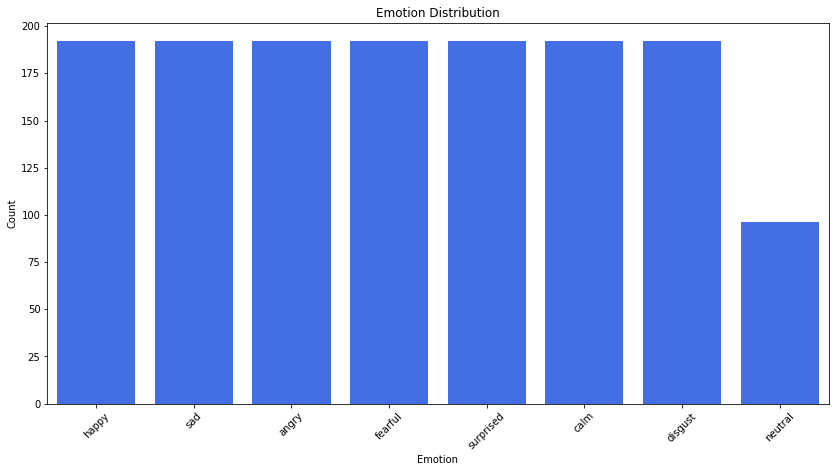

In [47]:
a = data.emotion_label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [40]:
ys=np.argmax(y_pred, axis=1)
ys.shape

(144,)

In [42]:
y_test.shape

(144, 8)